In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
batch_size = 64
# Learning rate
lr = 0.001
# Number of training epochs
num_epochs = 20

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [ ]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to dataset
# dataset_root_path = '/scratch2/datasets/cifar10/'
dataset_root_path = '/content/gdrive/My Drive/cifar10/'

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=dataset_root_path, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=dataset_root_path, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images



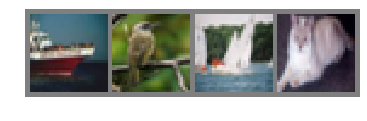

 ship  bird  ship   cat


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolutional Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net = net.to(device)

3. Define a Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)

4. Train the network

In [ ]:
# Helper function to test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
def eval(testloader, epoch):
    with torch.no_grad():
        running_loss_test = 0.0
        test_correct = 0
        test_total = 0
        test_i = 0
        for test_images, test_labels in testloader:
            # get the inputs
            # test_images, test_labels = test_data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            test_outputs = net(test_images)
            test_loss = criterion(test_outputs, test_labels)
            _, test_predicted = torch.max(test_outputs.data, 1)
            
            running_loss_test += test_loss.item()
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()
            test_i += 1

            if test_total >= testloader.dataset.test_data.shape[0]-batch_size:
                print('[{:d}], test accuracy: {:4.2f} %, test_loss {:.5f}'.format(epoch+1, \
                                                100*test_correct/test_total, running_loss_test/test_i))
                break
        return 100*test_correct/test_total, running_loss_test/test_i

In [ ]:
# Helper function to compute (true) training loss
# Eval on training data. This is to be run with initial model only
# In eval phase, we don't need to compute gradients (for memory efficiency)
def eval_initial_model(trainloader):
    with torch.no_grad():
        running_loss_train = 0.0
        train_correct = 0
        train_total = 0
        train_i = 0
        for train_images, train_labels in trainloader:
            # get the inputs
            # train_images, train_labels = train_data
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            train_outputs = net(train_images)
            train_loss = criterion(train_outputs, train_labels)
            _, train_predicted = torch.max(train_outputs.data, 1)
            
            running_loss_train += train_loss.item()
            train_total += train_labels.size(0)
            train_correct += (train_predicted == train_labels).sum().item()
            train_i += 1

        print('[0], train accuracy: {:4.2f} %, train_loss {:.5f}'.format(100*train_correct/train_total, \
                                                                        running_loss_train/train_i))
        return 100*train_correct/train_total, running_loss_train/train_i

In [ ]:
test_acc = [0.0]*(num_epochs+1)
test_loss = [0.0]*(num_epochs+1)
train_acc = [0.0]*(num_epochs+1)
train_loss = [0.0]*(num_epochs+1)
lst_counter = 0

train_acc[lst_counter], train_loss[lst_counter] = eval_initial_model(trainloader)
test_acc[lst_counter], test_loss[lst_counter] = eval(testloader, 0)
lst_counter += 1

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_training = 0.0
    correct = 0
    total = 0
    i = 0
    # for i, data in enumerate(trainloader, 0):
    for inputs, labels in trainloader:
        # get the inputs
        inputs = inputs.to(device); labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        training_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        
        training_loss.backward()
        optimizer.step()

        # print statistics
        running_loss_training += training_loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        i += 1
        if total >= trainloader.dataset.train_data.shape[0]:
            print('[{:d}] train accuracy: {:4.2f} % train loss: {:.5f}'.format(epoch+1, \
                                                            100*correct/total, running_loss_training/i))
            train_acc[lst_counter] = 100*correct/total
            train_loss[lst_counter] = running_loss_training/i
            
            running_loss_training = 0.0
            
            test_acc[lst_counter], test_loss[lst_counter] = eval(testloader, epoch)
            lst_counter += 1

print('Finished Training')

[0], train accuracy: 10.00 %, train_loss 2.30092
[1], test accuracy: 9.96 %, test_loss 2.30288
[1] train accuracy: 40.74 % train loss: 1.61012
[1], test accuracy: 49.21 %, test_loss 1.39504
[2] train accuracy: 52.25 % train loss: 1.32285
[2], test accuracy: 54.20 %, test_loss 1.25957
[3] train accuracy: 56.56 % train loss: 1.21228
[3], test accuracy: 56.88 %, test_loss 1.20294
[4] train accuracy: 59.36 % train loss: 1.14003
[4], test accuracy: 60.03 %, test_loss 1.12609
[5] train accuracy: 61.70 % train loss: 1.07300
[5], test accuracy: 59.70 %, test_loss 1.12261
[6] train accuracy: 63.64 % train loss: 1.01982
[6], test accuracy: 61.65 %, test_loss 1.08210
[7] train accuracy: 65.85 % train loss: 0.96916
[7], test accuracy: 62.39 %, test_loss 1.07559
[8] train accuracy: 67.10 % train loss: 0.92929
[8], test accuracy: 62.80 %, test_loss 1.05416
[9] train accuracy: 68.67 % train loss: 0.88925
[9], test accuracy: 63.77 %, test_loss 1.03570
[10] train accuracy: 69.95 % train loss: 0.85322
[

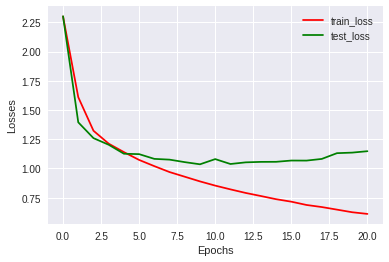

In [ ]:
# Plotting train and test loss vs Epochs
fig1 = plt.figure(1)        
plt.plot(range(num_epochs+1),train_loss,'r-',label='train_loss')        
plt.plot(range(num_epochs+1),test_loss,'g-',label='test_loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

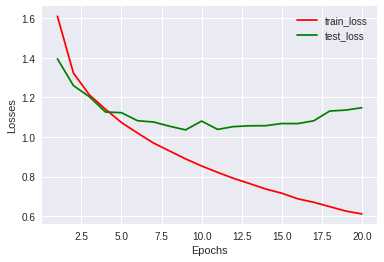

In [ ]:
fig2 = plt.figure(1)        
plt.plot(range(1, num_epochs+1),train_loss[1:],'r-',label='train_loss')        
plt.plot(range(1, num_epochs+1),test_loss[1:],'g-',label='test_loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.show()

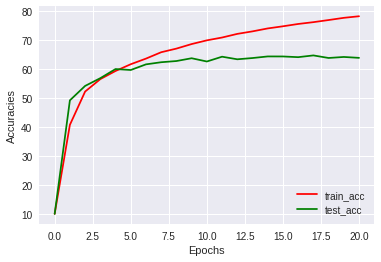

In [ ]:
# Plotting train and test accuracy vs Epochs
fig3 = plt.figure(1)        
plt.plot(range(num_epochs+1),train_acc,'r-',label='train_acc')        
plt.plot(range(num_epochs+1),test_acc,'g-',label='test_acc')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.show()

5. Test the network on the test data

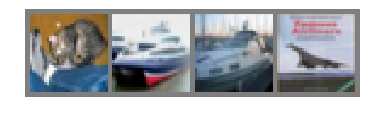

GroundTruth:    cat  ship  ship plane
Predicted:    dog (0.50) plane (0.85)  ship (0.67) plane (0.65)


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4], nrow=4))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Get the predicted outputs
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
outputs_softmax = F.softmax(outputs, dim=1)
probabilities, predicted = torch.max(outputs_softmax, 1)
probabilities_np = probabilities.cpu().data.numpy()
print('Predicted: ', ' '.join('%5s (%.2f)' % (classes[predicted[j]], probabilities[j]) for j in range(4)))